In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython import display

2025-04-15 17:38:04.307560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744738684.545541      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744738684.612441      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# GAN on MNIST Dataset

In [27]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [28]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

In [29]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [32]:
# Hyperparameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Modified train_step to return losses and accuracy
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # Compute discriminator accuracy (real vs. fake)
        real_pred = tf.cast(real_output > 0, tf.float32)
        fake_pred = tf.cast(fake_output <= 0, tf.float32)
        real_acc = tf.reduce_mean(real_pred)
        fake_acc = tf.reduce_mean(fake_pred)
        disc_acc = (real_acc + fake_acc) / 2
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, disc_acc

In [33]:
def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    disc_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = []
        epoch_disc_loss = []
        epoch_disc_acc = []
        
        for image_batch in dataset:
            g_loss, d_loss, d_acc = train_step(image_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)
            epoch_disc_acc.append(d_acc)
        
        # Average losses and accuracy for the epoch
        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))
        disc_accuracies.append(np.mean(epoch_disc_acc))
        
        # Generate images
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Save checkpoint
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f'Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')
        print(f'Epoch {epoch + 1}, Gen Loss: {gen_losses[-1]:.4f}, Disc Loss: {disc_losses[-1]:.4f}, Disc Acc: {disc_accuracies[-1]:.4f}')
    
    # Final generation
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), gen_losses, label='Generator Loss')
    plt.plot(range(1, epochs + 1), disc_losses, label='Discriminator Loss')
    plt.title('Generator vs. Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot discriminator accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), disc_accuracies, label='Discriminator Accuracy')
    plt.title('Discriminator Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return gen_losses, disc_losses, disc_accuracies

In [34]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

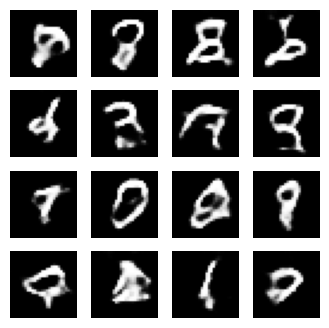

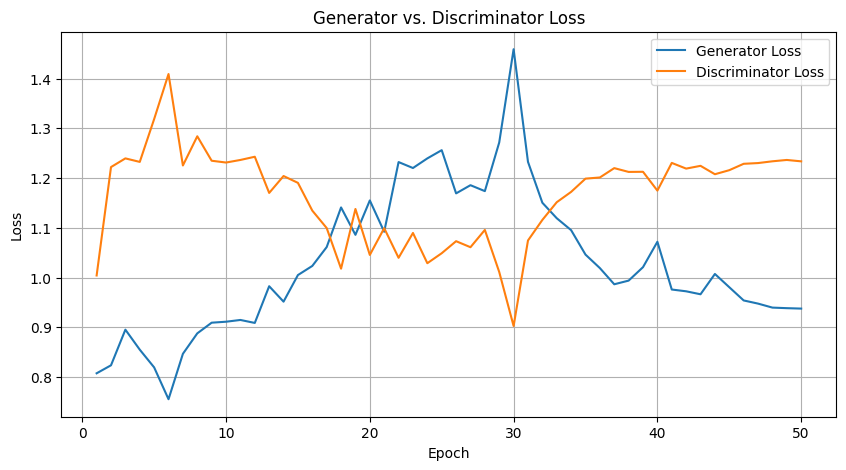

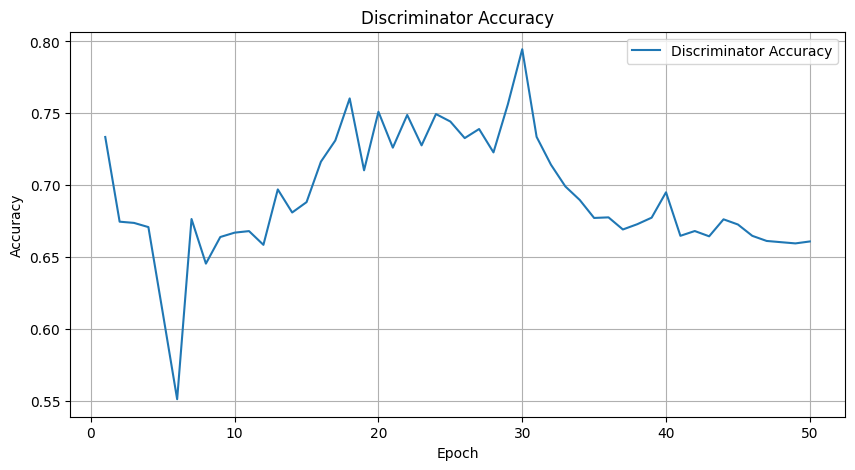

([0.80761033,
  0.8237215,
  0.89532304,
  0.8551207,
  0.8194862,
  0.7555,
  0.84678084,
  0.8878858,
  0.90933824,
  0.91129017,
  0.9148369,
  0.90884423,
  0.9826427,
  0.951649,
  1.0050969,
  1.023443,
  1.0613351,
  1.1410357,
  1.0859537,
  1.155089,
  1.0921057,
  1.2322271,
  1.2202668,
  1.2396069,
  1.2561463,
  1.169272,
  1.1857355,
  1.1738008,
  1.2716335,
  1.4590597,
  1.2326751,
  1.1504545,
  1.1193354,
  1.09536,
  1.0462073,
  1.0190933,
  0.9865621,
  0.99393725,
  1.0209732,
  1.0720061,
  0.97601867,
  0.97243506,
  0.9664687,
  1.0072854,
  0.9806526,
  0.95405805,
  0.94770676,
  0.93967247,
  0.9385367,
  0.9376904],
 [1.0042254,
  1.222175,
  1.2396176,
  1.2325455,
  1.3186167,
  1.4092014,
  1.2253711,
  1.2840608,
  1.2348828,
  1.2312887,
  1.2364768,
  1.2429107,
  1.1701826,
  1.204158,
  1.1904367,
  1.1346129,
  1.0996004,
  1.0179224,
  1.137922,
  1.0455421,
  1.0993981,
  1.0397655,
  1.089703,
  1.0289047,
  1.0489777,
  1.0731682,
  1.0610673,

In [35]:
# Run training
train(train_dataset, EPOCHS)

# GAN on CIFAR-10 Dataset

In [2]:
# Load and preprocess CIFAR-10
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
BUFFER_SIZE = 50000  # CIFAR-10 has 50,000 training images
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


I0000 00:00:1744738839.783146      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744738839.783852      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
# Generator model for CIFAR-10
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)
    
    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 8, 8, 256)
    
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 16, 16, 128)
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 32, 32, 64)
    
    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)
    
    return model

# Discriminator model for CIFAR-10
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    
    return model

# Initialize models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Adjusted for CIFAR-10
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoint setup
checkpoint_dir = './training_checkpoints_cifar10'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Hyperparameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # Discriminator accuracy
        real_pred = tf.cast(real_output > 0, tf.float32)
        fake_pred = tf.cast(fake_output <= 0, tf.float32)
        real_acc = tf.reduce_mean(real_pred)
        fake_acc = tf.reduce_mean(fake_pred)
        disc_acc = (real_acc + fake_acc) / 2
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, disc_acc

# Training loop with loss and accuracy collection
def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    disc_accuracies = []
    
    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = []
        epoch_disc_loss = []
        epoch_disc_acc = []
        
        for image_batch in dataset:
            g_loss, d_loss, d_acc = train_step(image_batch)
            epoch_gen_loss.append(g_loss)
            epoch_disc_loss.append(d_loss)
            epoch_disc_acc.append(d_acc)
        
        # Average losses and accuracy
        gen_losses.append(np.mean(epoch_gen_loss))
        disc_losses.append(np.mean(epoch_disc_loss))
        disc_accuracies.append(np.mean(epoch_disc_acc))
        
        # Generate images
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        
        # Save checkpoint
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f'Time for epoch {epoch + 1}: {time.time() - start:.2f} sec')
        print(f'Epoch {epoch + 1}, Gen Loss: {gen_losses[-1]:.4f}, Disc Loss: {disc_losses[-1]:.4f}, Disc Acc: {disc_accuracies[-1]:.4f}')
    
    # Final generation
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), gen_losses, label='Generator Loss')
    plt.plot(range(1, epochs + 1), disc_losses, label='Discriminator Loss')
    plt.title('Generator vs. Discriminator Loss (CIFAR-10)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot discriminator accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), disc_accuracies, label='Discriminator Accuracy')
    plt.title('Discriminator Accuracy (CIFAR-10)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return gen_losses, disc_losses, disc_accuracies

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        # Denormalize: [-1, 1] to [0, 1] for display
        img = (predictions[i] * 0.5 + 0.5).numpy()
        plt.imshow(img)
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

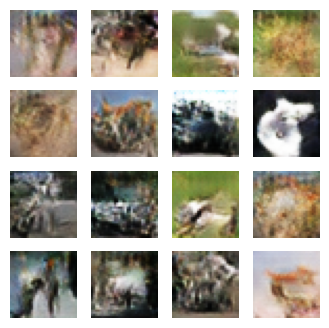

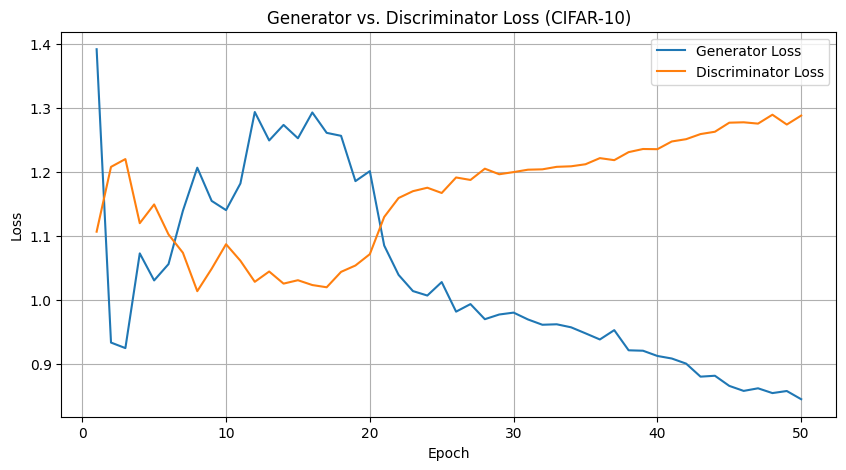

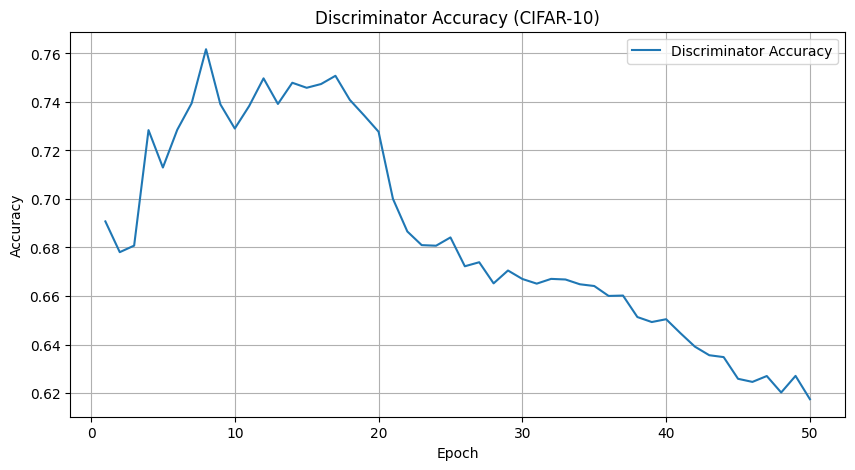

([1.3920779,
  0.9327862,
  0.9241205,
  1.0724148,
  1.0301018,
  1.05565,
  1.1391327,
  1.2066029,
  1.1545962,
  1.1401664,
  1.1818871,
  1.2937443,
  1.2492566,
  1.2735624,
  1.2526588,
  1.2930545,
  1.2611392,
  1.2564908,
  1.1855661,
  1.2011858,
  1.0847213,
  1.0387764,
  1.0133946,
  1.0064212,
  1.027489,
  0.9811949,
  0.99303573,
  0.96938354,
  0.97672546,
  0.97969216,
  0.9689606,
  0.9606829,
  0.9614102,
  0.9566544,
  0.9472464,
  0.9376368,
  0.9522466,
  0.9206729,
  0.9200203,
  0.91181964,
  0.9078337,
  0.89980906,
  0.87942624,
  0.88083297,
  0.8649592,
  0.85711426,
  0.8611819,
  0.8536903,
  0.85693955,
  0.8440845],
 [1.1063824,
  1.20787,
  1.2200795,
  1.1197065,
  1.1490715,
  1.1020553,
  1.0734196,
  1.0132495,
  1.0483698,
  1.0867451,
  1.0608743,
  1.0279133,
  1.0440372,
  1.0250893,
  1.0304033,
  1.0228575,
  1.0193673,
  1.0434818,
  1.0534602,
  1.0711877,
  1.1294444,
  1.159112,
  1.1698188,
  1.1752229,
  1.1669866,
  1.1912773,
  1.187

In [5]:
# Run training
train(train_dataset, EPOCHS)

In [12]:
import kagglehub
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
gauravduttakiit_dogs_breed_dataset_path = kagglehub.dataset_download('gauravduttakiit/dogs-breed-dataset')
gauravduttakiit_mobilenet_v2_dog_classification_path = kagglehub.dataset_download('gauravduttakiit/mobilenet-v2-dog-classification')

print('Data source import complete.')

Data source import complete.


In [2]:
import pandas as pd
train=pd.read_csv('/kaggle/input/dogs-breed-dataset/train.csv')
train.head()

,filename,label
0,/kaggle/input/dogs-breed-dataset/dog_v1/poodle...,poodle
1,/kaggle/input/dogs-breed-dataset/dog_v1/french...,french_bulldog
2,/kaggle/input/dogs-breed-dataset/dog_v1/french...,french_bulldog
3,/kaggle/input/dogs-breed-dataset/dog_v1/french...,french_bulldog
4,/kaggle/input/dogs-breed-dataset/dog_v1/french...,french_bulldog


In [3]:
test=pd.read_csv('/kaggle/input/dogs-breed-dataset/test.csv')
test.head()

,filename,label
0,/kaggle/input/dogs-breed-dataset/dog_v1/poodle...,poodle
1,/kaggle/input/dogs-breed-dataset/dog_v1/yorksh...,yorkshire_terrier
2,/kaggle/input/dogs-breed-dataset/dog_v1/yorksh...,yorkshire_terrier
3,/kaggle/input/dogs-breed-dataset/dog_v1/yorksh...,yorkshire_terrier
4,/kaggle/input/dogs-breed-dataset/dog_v1/golden...,golden_retriever


In [4]:
train['filename']=train['filename'].str.replace('/kaggle/input/dogs-breed-dataset/dog_v1/','/kaggle/input/dogs-breed-dataset/train/')
train.head()

,filename,label
0,/kaggle/input/dogs-breed-dataset/train/poodle/...,poodle
1,/kaggle/input/dogs-breed-dataset/train/french_...,french_bulldog
2,/kaggle/input/dogs-breed-dataset/train/french_...,french_bulldog
3,/kaggle/input/dogs-breed-dataset/train/french_...,french_bulldog
4,/kaggle/input/dogs-breed-dataset/train/french_...,french_bulldog


In [5]:
test['filename']=test['filename'].str.replace('/kaggle/input/dogs-breed-dataset/dog_v1/','/kaggle/input/dogs-breed-dataset/test/')
test.head()

,filename,label
0,/kaggle/input/dogs-breed-dataset/test/poodle/b...,poodle
1,/kaggle/input/dogs-breed-dataset/test/yorkshir...,yorkshire_terrier
2,/kaggle/input/dogs-breed-dataset/test/yorkshir...,yorkshire_terrier
3,/kaggle/input/dogs-breed-dataset/test/yorkshir...,yorkshire_terrier
4,/kaggle/input/dogs-breed-dataset/test/golden_r...,golden_retriever


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Apply rescaling and augmentations (for training)
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),  # standard size for MobileNetV2
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    shuffle=True
)

Found 660 validated image filenames belonging to 5 classes.
Found 164 validated image filenames belonging to 5 classes.


In [9]:
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

Number of classes: 5


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Large

input_shape = (224, 224, 3)
num_classes = len(train_generator.class_indices)

In [11]:
def build_mobilenet_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [12]:
base_model_v1 = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
model_v1 = build_mobilenet_model(base_model_v1)

I0000 00:00:1744901555.520152      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744901555.520796      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
base_model_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
model_v2 = build_mobilenet_model(base_model_v2)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
base_model_v3 = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape)
model_v3 = build_mobilenet_model(base_model_v3)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# MobileNet V1
history_v1 = model_v1.fit(train_generator, validation_data=val_generator, epochs=10)

# MobileNet V2
history_v2 = model_v2.fit(train_generator, validation_data=val_generator, epochs=10)

# MobileNet V3
history_v3 = model_v3.fit(train_generator, validation_data=val_generator, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
I0000 00:00:1744901654.354410     112 service.cc:148] XLA service 0x7a53c8211d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744901654.355364     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744901654.355386     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744901656.228006     112 cuda_dnn.cc:5

 1/21 ━━━━━━━━━━━━━━━━━━━━ 15:21 46s/step - accuracy: 0.1875 - loss: 2.3496

I0000 00:00:1744901668.235062     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 4/21 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2070 - loss: 2.2914   

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4505 - loss: 1.5245 - val_accuracy: 0.7622 - val_loss: 0.7092
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 946ms/step - accuracy: 0.9766 - loss: 0.1429 - val_accuracy: 0.8598 - val_loss: 0.4292
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 965ms/step - accuracy: 0.9943 - loss: 0.0440 - val_accuracy: 0.9146 - val_loss: 0.3170
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 924ms/step - accuracy: 0.9976 - loss: 0.0303 - val_accuracy: 0.9268 - val_loss: 0.2985
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 948ms/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 0.9329 - val_loss: 0.3037
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 904ms/step - accuracy: 0.9987 - loss: 0.0125 - val_accuracy: 0.9390 - val_loss: 0.2767
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 888ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9329 - val_loss: 0.2587
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 910ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.9451 -

E0000 00:00:1744902363.924051     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744902364.064295     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744902364.470123     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744902364.609153     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


10/21 ━━━━━━━━━━━━━━━━━━━━ 10s 992ms/step - accuracy: 0.1464 - loss: 2.2455

E0000 00:00:1744902397.906097     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744902398.042764     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744902398.352525     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744902398.491517     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


21/21 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.1940 - loss: 2.0606 - val_accuracy: 0.2561 - val_loss: 1.6979
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 944ms/step - accuracy: 0.6536 - loss: 0.9661 - val_accuracy: 0.2561 - val_loss: 1.6929
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 951ms/step - accuracy: 0.8290 - loss: 0.5338 - val_accuracy: 0.2561 - val_loss: 1.6963
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 929ms/step - accuracy: 0.9421 - loss: 0.2730 - val_accuracy: 0.2561 - val_loss: 1.6921
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 879ms/step - accuracy: 0.9519 - loss: 0.1881 - val_accuracy: 0.2561 - val_loss: 1.6972
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 928ms/step - accuracy: 0.9888 - loss: 0.1189 - val_accuracy: 0.2561 - val_loss: 1.7021
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 912ms/step - accuracy: 0.9869 - loss: 0.0893 - val_accuracy: 0.2561 - val_loss: 1.7081
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 931ms/step - accuracy: 0.9969 - loss: 0.0563 - val_accuracy: 0.2561 

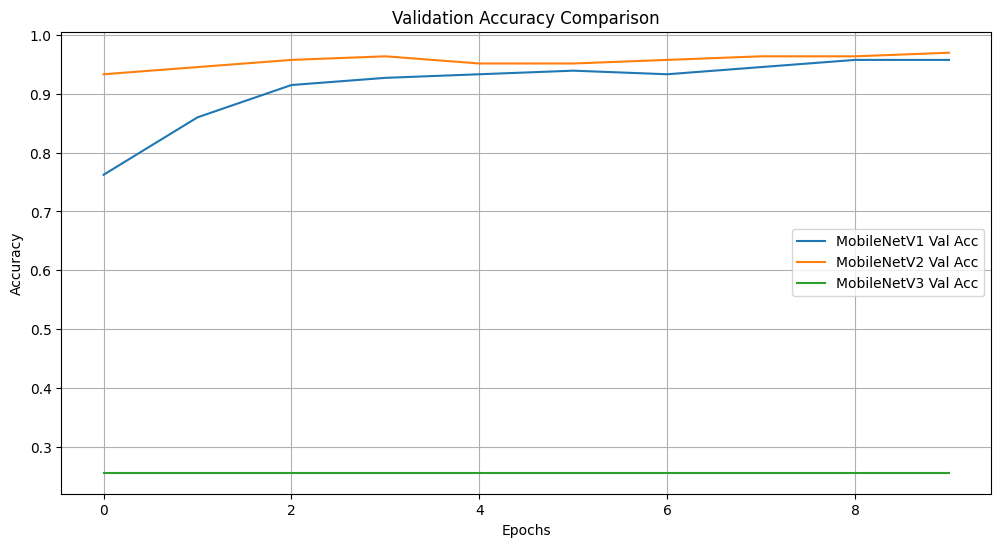

In [16]:
import matplotlib.pyplot as plt

def plot_accuracy(histories, names):
    plt.figure(figsize=(12, 6))
    for history, name in zip(histories, names):
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Acc')
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy([history_v1, history_v2, history_v3], ["MobileNetV1", "MobileNetV2", "MobileNetV3"])

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 206 validated image filenames belonging to 5 classes.


In [18]:
# Evaluate all three models
v1_eval = model_v1.evaluate(test_generator)
v2_eval = model_v2.evaluate(test_generator)
v3_eval = model_v3.evaluate(test_generator)

print(f"MobileNetV1 - Test Accuracy: {v1_eval[1]:.4f}")
print(f"MobileNetV2 - Test Accuracy: {v2_eval[1]:.4f}")
print(f"MobileNetV3 - Test Accuracy: {v3_eval[1]:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9905 - loss: 0.0617
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9895 - loss: 0.0260
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2184 - loss: 1.8560
MobileNetV1 - Test Accuracy: 0.9903
MobileNetV2 - Test Accuracy: 0.9806
MobileNetV3 - Test Accuracy: 0.2330


In [19]:
from sklearn.metrics import classification_report
import numpy as np

# Get ground truth labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Predict with MobileNetV2 
y_pred_v2 = model_v2.predict(test_generator)
y_pred_classes_v2 = np.argmax(y_pred_v2, axis=1)

print("Classification Report for MobileNetV2:")
print(classification_report(true_labels, y_pred_classes_v2, target_names=class_labels))

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step 
Classification Report for MobileNetV2:
                   precision    recall  f1-score   support

   french_bulldog       1.00      0.98      0.99        45
  german_shepherd       0.98      0.98      0.98        48
 golden_retriever       0.96      1.00      0.98        46
           poodle       1.00      0.92      0.96        24
yorkshire_terrier       0.98      1.00      0.99        43

         accuracy                           0.98       206
        macro avg       0.98      0.97      0.98       206
     weighted avg       0.98      0.98      0.98       206



In [20]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.show()

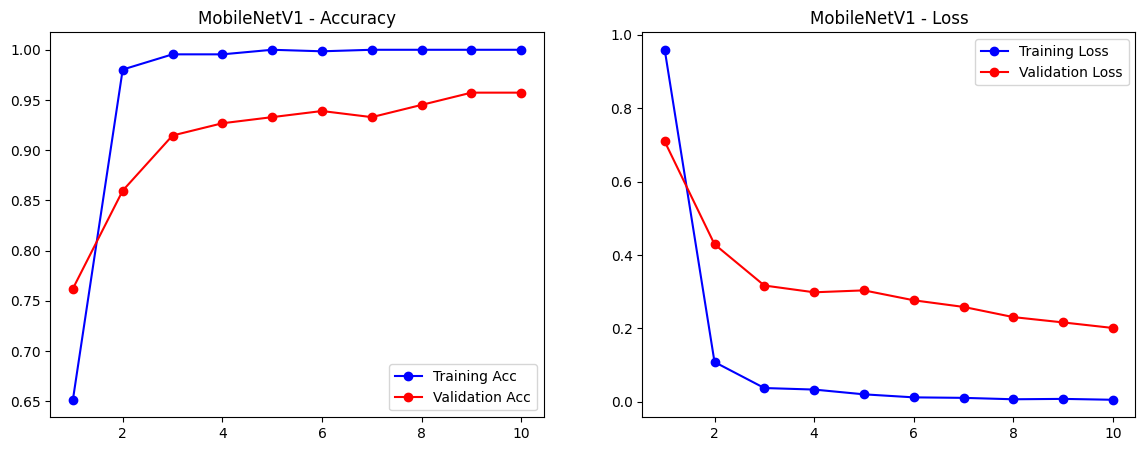

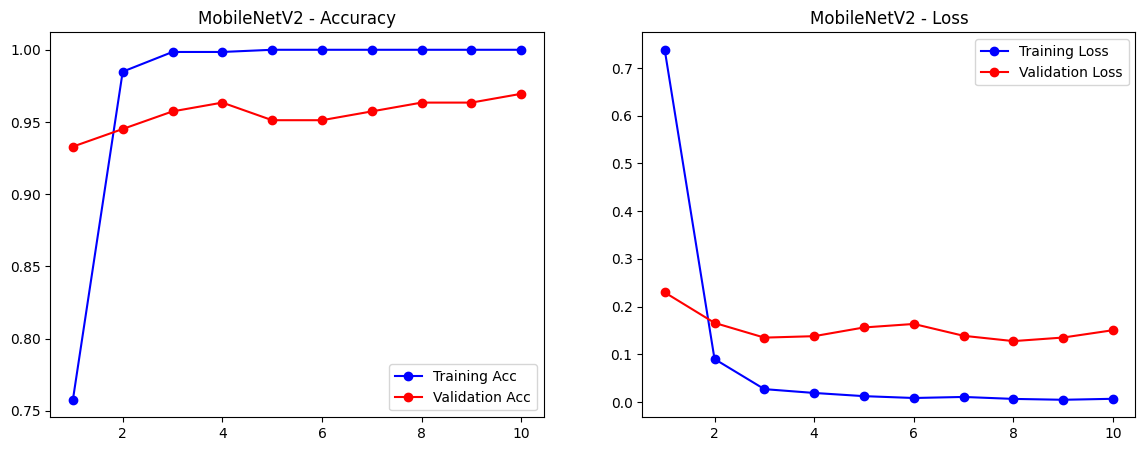

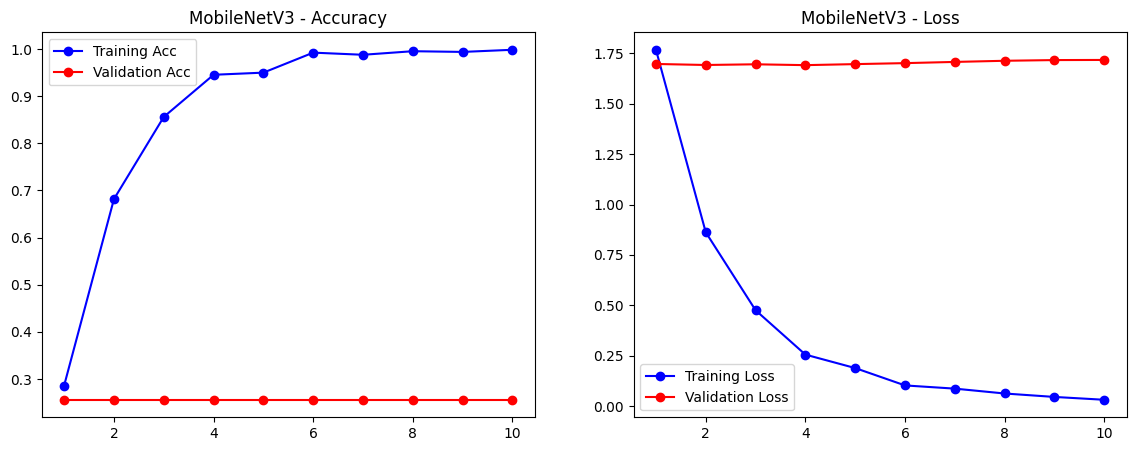

In [21]:
plot_history(history_v1, "MobileNetV1")
plot_history(history_v2, "MobileNetV2")
plot_history(history_v3, "MobileNetV3")

**MobileNetV3**

In [6]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as preprocess_input_v3

2025-04-17 18:44:52.906149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744915493.092448      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744915493.145777      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = 224
batch_size = 32

train_datagen_v3 = ImageDataGenerator(
    preprocessing_function=preprocess_input_v3,
    validation_split=0.2
)

train_generator_v3 = train_datagen_v3.flow_from_dataframe(
    dataframe=train,
    x_col='filename',
    y_col='label',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator_v3 = train_datagen_v3.flow_from_dataframe(
    dataframe=train,
    x_col='filename',
    y_col='label',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen_v3 = ImageDataGenerator(preprocessing_function=preprocess_input_v3)
test_generator_v3 = test_datagen_v3.flow_from_dataframe(
    dataframe=test,
    x_col='filename',
    y_col='label',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 660 validated image filenames belonging to 5 classes.
Found 164 validated image filenames belonging to 5 classes.
Found 206 validated image filenames belonging to 5 classes.


In [9]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model_v3 = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model_v3.trainable = False  # freeze base model

num_classes = len(train_generator_v3.class_indices)

x = base_model_v3.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_v3 = Model(inputs=base_model_v3.input, outputs=outputs)

model_v3.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_v3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 16)   │            144 │ activation_20[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 112, 112, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            256 │ re_lu_19[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 112, 112, 16)   │              0 │ activation_20[0][0],   │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 112, 112, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 112, 112, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 112, 112, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 3,120,005 (11.90 MB)

 Trainable params: 123,653 (483.02 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [10]:
history_v3 = model_v3.fit(
    train_generator_v3,
    validation_data=val_generator_v3,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744915670.329783     104 service.cc:148] XLA service 0x7fe6081126c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744915670.330564     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744915670.330591     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744915671.519643     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/21 ━━━━━━━━━━━━━━━━━━━━ 8:41 26s/step - accuracy: 0.1875 - loss: 2.7395

I0000 00:00:1744915677.357759     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 8/21 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.2302 - loss: 2.3343

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


12/21 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2440 - loss: 2.2555

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.2733 - loss: 2.0872 - val_accuracy: 0.6829 - val_loss: 0.9503
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 966ms/step - accuracy: 0.6453 - loss: 0.9722 - val_accuracy: 0.9024 - val_loss: 0.4955
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 836ms/step - accuracy: 0.8309 - loss: 0.5862 - val_accuracy: 0.9268 - val_loss: 0.3151
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 903ms/step - accuracy: 0.8953 - loss: 0.3820 - val_accuracy: 0.9451 - val_loss: 0.2373
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 929ms/step - accuracy: 0.9466 - loss: 0.2470 - val_accuracy: 0.9451 - val_loss: 0.2029
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 830ms/step - accuracy: 0.9479 - loss: 0.2221 - val_accuracy: 0.9451 - val_loss: 0.1771
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 882ms/step - accuracy: 0.9493 - loss: 0.1722 - val_accuracy: 0.9451 - val_loss: 0.1577
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 859ms/step - accuracy: 0.9696 - loss: 0.1617 - val_accuracy: 0.9451 -

In [14]:
val_loss, val_accuracy = model_v3.evaluate(val_generator_v3)
print(f"MobileNetV3 - Validation Accuracy: {val_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 742ms/step - accuracy: 0.9383 - loss: 0.1307
MobileNetV3 - Validation Accuracy: 0.9451


In [11]:
test_loss, test_acc = model_v3.evaluate(test_generator_v3)
print(f"✅ MobileNetV3 - Test Accuracy: {test_acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9826 - loss: 0.0682
✅ MobileNetV3 - Test Accuracy: 0.9854


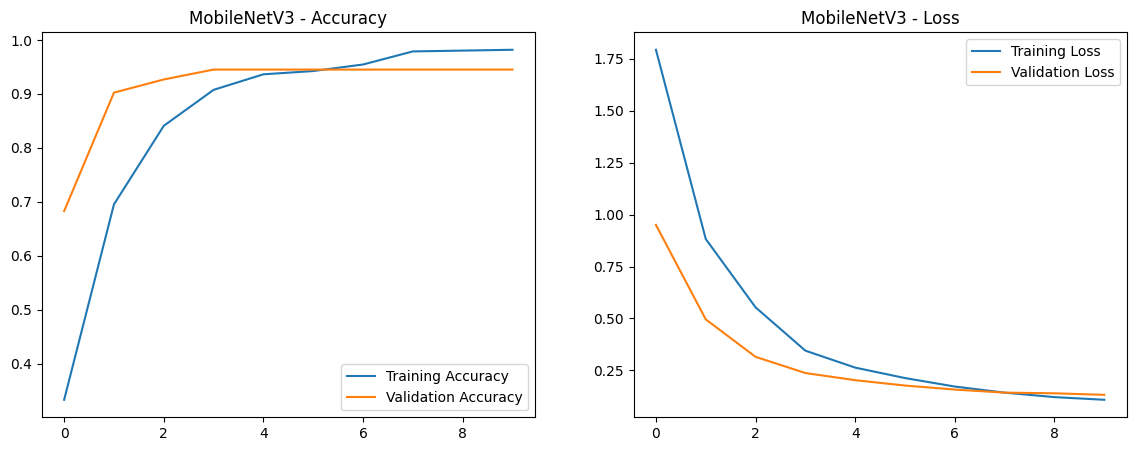

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')

    plt.show()

plot_training_history(history_v3, "MobileNetV3")

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from uuid import uuid4

2025-04-20 12:01:45.882534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745150506.091130      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745150506.148953      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the Oxford-IIIT Pet Dataset using as_data_source
print("Loading Oxford-IIIT Pet Dataset...")
builder = tfds.builder('oxford_iiit_pet:4.0.0')
info = builder.info
print("Dataset info:", info)

# Download and prepare the dataset if not already done
builder.download_and_prepare()

# Load train and test splits as data sources
train_data_source = builder.as_data_source(split='train')
test_data_source = builder.as_data_source(split='test')

Loading Oxford-IIIT Pet Dataset...
Dataset info: tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpwwhp44zvtfds'),
    file_format=array_record,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), d

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

I0000 00:00:1745150583.027124      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745150583.027797      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.BL3WL5_4.0.0/oxford_iiit_pet-train.array_record…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.BL3WL5_4.0.0/oxford_iiit_pet-test.array_record*…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [3]:
# Preprocessing functions
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
    return input_image, input_mask

def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1  # Adjust mask labels to 0-based
    return input_image, input_mask

print("Resizing images and masks to 128x128...")
print("Applying data augmentation...")
print("Normalizing images and masks...")

def preprocess_datapoint(datapoint):
    input_image = tf.convert_to_tensor(datapoint["image"])
    input_mask = tf.convert_to_tensor(datapoint["segmentation_mask"])
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def preprocess_test_datapoint(datapoint):
    input_image = tf.convert_to_tensor(datapoint["image"])
    input_mask = tf.convert_to_tensor(datapoint["segmentation_mask"])
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

# Process data source into lists
print("Processing data source...")
train_images = []
train_masks = []
test_images = []
test_masks = []

for datapoint in train_data_source:
    img, mask = preprocess_datapoint(datapoint)
    train_images.append(img.numpy())
    train_masks.append(mask.numpy())

for datapoint in test_data_source:
    img, mask = preprocess_test_datapoint(datapoint)
    test_images.append(img.numpy())
    test_masks.append(mask.numpy())

# Convert lists to NumPy arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

Resizing images and masks to 128x128...
Applying data augmentation...
Normalizing images and masks...
Processing data source...


Creating TensorFlow datasets...
Displaying sample image and mask from training set...


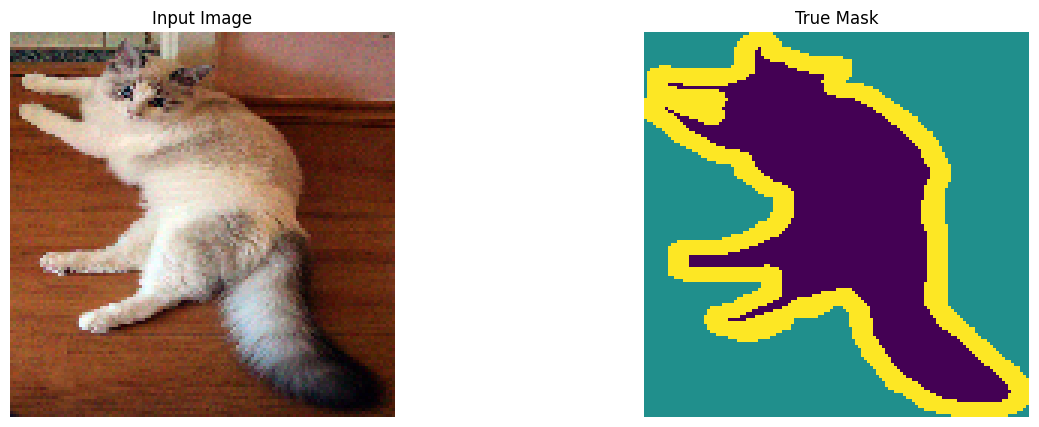

In [4]:
# Create TensorFlow datasets
BATCH_SIZE = 64
BUFFER_SIZE = 1000
print("Creating TensorFlow datasets...")
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

# Display sample images
def display(display_list, titles=["Input Image", "True Mask", "Predicted Mask"]):
    plt.figure(figsize=(15, 5))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.savefig(f'sample_display_{uuid4().hex}.png')
    plt.show()
    plt.close()

print("Displaying sample image and mask from training set...")
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask], ["Input Image", "True Mask"])

In [5]:
# U-Net model components
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

# Build U-Net model
def build_unet_model():
    print("Building U-Net model...")
    inputs = layers.Input(shape=(128, 128, 3))
    
    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)
    
    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    
    # Output
    outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)
    
    return tf.keras.Model(inputs, outputs, name="U-Net")

unet_model = build_unet_model()
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])
print("U-Net model compiled.")

Building U-Net model...
U-Net model compiled.


Starting model training...
Epoch 1/20


I0000 00:00:1745151093.535802     121 service.cc:148] XLA service 0x794c40028400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745151093.538049     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745151093.538072     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1745151094.210783     121 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1745151094.635698     121 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-20 12:11:48.581105: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng50{} for conv (f32[64,512,17,17]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1024,8,8]{3,2,1,0}, f32[1024,512,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwar

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.5338 - loss: 1.3570

W0000 00:00:1745151229.731993     121 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


57/57 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.5344 - loss: 1.3517 - val_accuracy: 0.6068 - val_loss: 0.8166
Epoch 2/20


W0000 00:00:1745151253.880168     121 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


57/57 ━━━━━━━━━━━━━━━━━━━━ 110s 943ms/step - accuracy: 0.6650 - loss: 0.7911 - val_accuracy: 0.7141 - val_loss: 0.7008
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 929ms/step - accuracy: 0.7303 - loss: 0.6650 - val_accuracy: 0.7357 - val_loss: 0.6498
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 936ms/step - accuracy: 0.7503 - loss: 0.6159 - val_accuracy: 0.7717 - val_loss: 0.5798
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.7702 - loss: 0.5737

W0000 00:00:1745151519.675850     119 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


57/57 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7703 - loss: 0.5735 - val_accuracy: 0.8012 - val_loss: 0.4984
Epoch 6/20


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 935ms/step - accuracy: 0.7829 - loss: 0.5502 - val_accuracy: 0.8118 - val_loss: 0.4762
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 939ms/step - accuracy: 0.8143 - loss: 0.4781 - val_accuracy: 0.8355 - val_loss: 0.4231
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 941ms/step - accuracy: 0.8299 - loss: 0.4394 - val_accuracy: 0.8359 - val_loss: 0.4250
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 938ms/step - accuracy: 0.8416 - loss: 0.4103 - val_accuracy: 0.8497 - val_loss: 0.3937
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 889ms/step - accuracy: 0.8503 - loss: 0.3872 - val_accuracy: 0.8593 - val_loss: 0.3701
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 937ms/step - accuracy: 0.8565 - loss: 0.3722 - val_accuracy: 0.8566 - val_loss: 0.3723
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 940ms/step - accuracy: 0.8567 - loss: 0.3709 - val_accuracy: 0.8655 - val_loss: 0.3486
Epoch 13/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 940ms/step - accuracy: 0.8662 - loss: 0.3450 - val_accuracy: 0

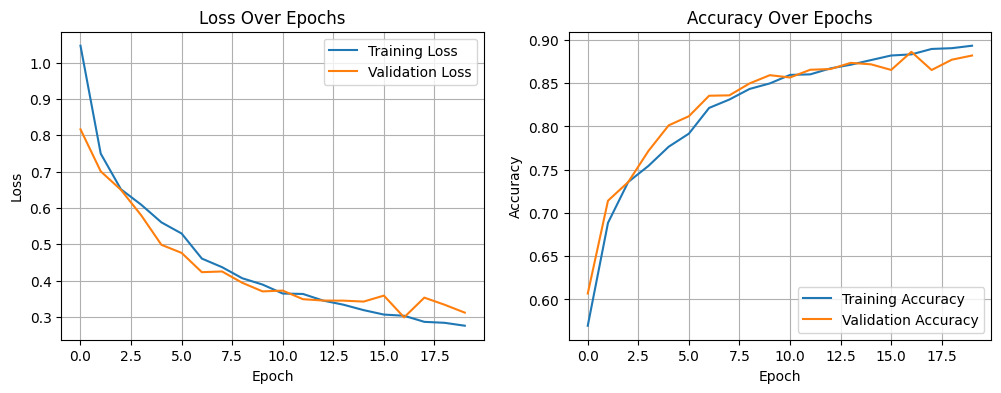

In [6]:
# Training parameters
NUM_EPOCHS = 20
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

# Train the model
print("Starting model training...")
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=validation_batches)

# Plot training history
print("Plotting training history...")
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.savefig('training_history.png')
plt.show()
plt.close()

# Evaluation metrics (IoU and Dice Coefficient)
def iou_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

# Create mask from predictions
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# Show predictions
def show_predictions(dataset=None, num=1):
    print(f"Generating predictions for {num} samples...")
    for image, mask in dataset.take(num):
        pred_mask = unet_model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

Evaluating model on test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


E0000 00:00:1745152384.581209     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745152384.833550     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
Mean IoU: 1.2717
Mean Dice Coefficient: 1.1093
Displaying predictions on test set...
Generating predictions for 3 samples...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


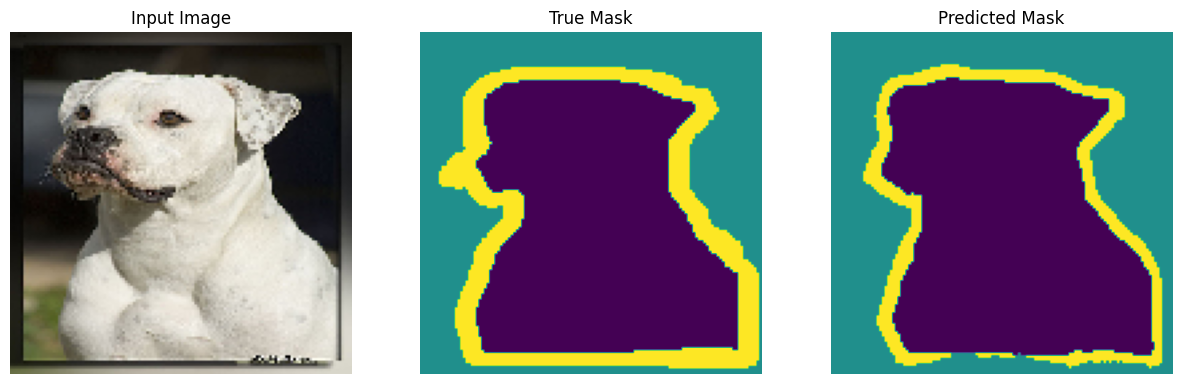

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


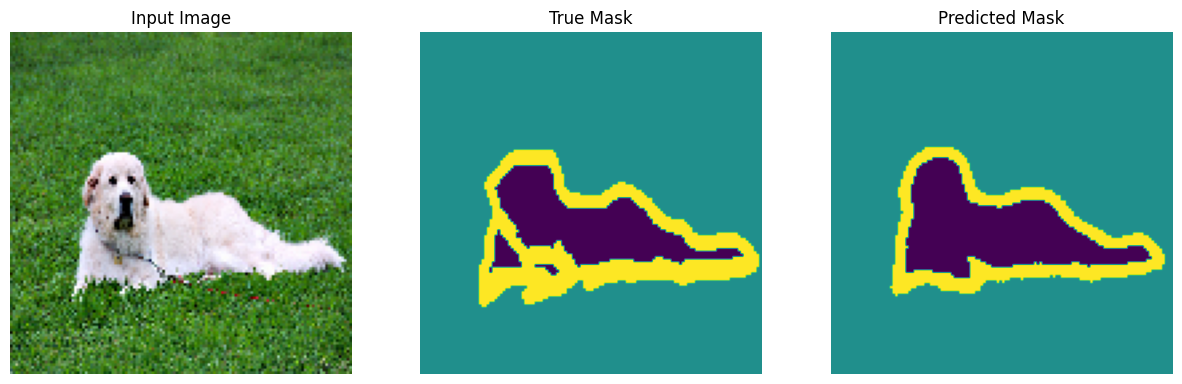

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


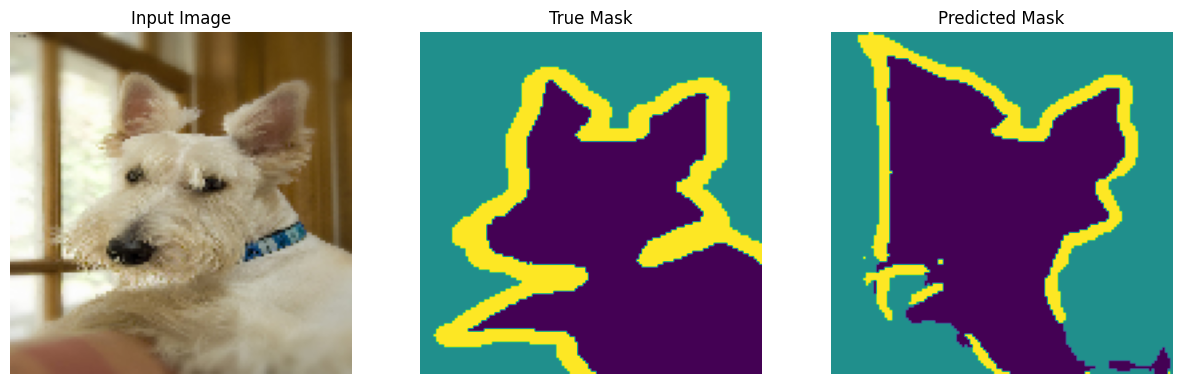

Number of test batches: 11


In [7]:
# Evaluate model
print("Evaluating model on test set...")
iou_scores = []
dice_scores = []

for image, mask in test_batches:
    pred_mask = unet_model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)[..., tf.newaxis]
    mask = tf.cast(mask, tf.int64)
    
    for i in range(image.shape[0]):
        iou = iou_score(mask[i], pred_mask[i])
        dice = dice_coefficient(mask[i], pred_mask[i])
        iou_scores.append(iou)
        dice_scores.append(dice)

mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")

# Display predictions on test set
print("Displaying predictions on test set...")
show_predictions(test_batches, num=3)

# Count number of test batches
count = 0
for _ in test_batches:
    count += 1
print("Number of test batches:", count)